In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import pandas as pd
import time

## Algorithms (lambda - ruin, Perotto)

In [1]:
### Lambda Ruin Adverse Policy ####
def simulate_bandit(k, aa, nplays, b0, lam, M, arm,rseed, UCBPerotto):
    Qmat = np.zeros((nplays + 1, k))
    Obmat = np.zeros((nplays + 1, k))
    UCBmat = np.full((nplays + 1, k),1e12)
    ActionVec = np.zeros(nplays, dtype=int)
    RewardVec = np.zeros(nplays) #we can think of Rewards starting only at time 1
    budget = np.zeros(nplays + 1)
    budget[0] = b0
    isRuined = False
    np.random.seed(rseed)
    
    for tt in range(nplays):
        ActionVec[tt] = np.random.choice(np.flatnonzero(Obmat[tt,:] == Obmat[tt,:].max())) + 1
        RewardVec[tt] = arm(ActionVec[tt])

        # Update budget
        if budget[tt] + RewardVec[tt] < 0:
            isRuined = True
            return Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, (tt + 1)
        budget[tt + 1] = budget[tt] + RewardVec[tt]
        past_rewards = RewardVec[:tt+1] ## excluses the t+1 th element
        past_actions = ActionVec[:tt+1]
        UCBvalue = tt + 1
        if UCBPerotto == True:
            UCBvalue = budget[tt+1] + 1

        # Calculate ruin probabilities using bootstrap
        remaining_plays = nplays - (tt + 1)
        if remaining_plays > 0:
            for a in range(1,k+1):
                SetRewards = past_rewards[past_actions == a]
                if len(SetRewards) != 0:
                    bootStrapRewards = np.random.choice(SetRewards, size=(M, remaining_plays), replace=True)
                    cum_rewards = np.cumsum(bootStrapRewards, axis=1)
                    ruin_samples = np.any(cum_rewards + budget[tt + 1] <= 0, axis=1)
                    Qmat[tt + 1, a-1] = ((-budget[tt + 1] - lam)*sum(ruin_samples) + np.sum(cum_rewards[:,remaining_plays-1][~ruin_samples]))/M
                    UCBmat[tt + 1, a-1] = np.sqrt(aa * np.log(UCBvalue)) / max(1, np.sum(past_actions == a))
        Obmat[tt + 1,:] = Qmat[tt + 1,:]+ UCBmat[tt + 1,:] #####(nplays+1 - tt)
    return Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, nplays+1

In [228]:
### Perotto Ruin Adverse Policy ###
def simulate_bandit_MAB(k, aa, nplays, b0, lam, M, arm,rseed, UCBPerotto):
    # Initialize matrices and vectors
    Qmat = np.zeros((nplays + 1, k))
    Pmat = np.zeros((nplays + 1, k))
    Obmat = np.zeros((nplays + 1, k))
    UCBmat = np.full((nplays + 1, k),1e12)
    ActionVec = np.zeros(nplays, dtype=int)
    RewardVec = np.zeros(nplays) #we can think of Rewards starting only at time 1
    budget = np.zeros(nplays + 1)
    budget[0] = b0
    isRuined = False
    np.random.seed(rseed)
    
    for tt in range(nplays):
        ActionVec[tt] = np.random.choice(np.flatnonzero(Obmat[tt,:] == Obmat[tt,:].max())) + 1
        #ActionVec[tt] = np.random.choice(np.arange(1,k+1)) #the random policy

        RewardVec[tt] = arm(ActionVec[tt])
        # Update budget
        if budget[tt] + RewardVec[tt] < 0:
            isRuined = True
            return Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, (tt + 1)
        budget[tt + 1] = budget[tt] + RewardVec[tt]
        
        # Carry forward Q-values and ruin probabilities for non-selected actions
        Qmat[tt + 1, :] = Qmat[tt, :]

        # Update Q-value for the selected action
        past_rewards = RewardVec[:tt+1] ## excluses the t+1 th element
        past_actions = ActionVec[:tt+1]
        Qmat[tt + 1, ActionVec[tt] - 1] = np.mean(past_rewards[past_actions == ActionVec[tt]])
        UCBvalue = tt + 1
        if UCBPerotto == True:
            UCBvalue = budget[tt+1] + 1

        # Calculate ruin probabilities using bootstrap
        remaining_plays = nplays - (tt + 1)
        if remaining_plays > 0:
            for a in range(1,k+1):
                ruin_samples = np.zeros(M, dtype=bool)
                SetRewards = past_rewards[past_actions == a]
                if len(SetRewards) != 0:
                    bootStrapRewards = np.random.choice(SetRewards, size=(M, remaining_plays), replace=True)
                    cum_rewards = np.cumsum(bootStrapRewards, axis=1)
                    ruin_samples = np.any(cum_rewards + budget[tt + 1] < 0, axis=1)
                    Pmat[tt + 1, a-1] = np.mean(ruin_samples)
                    UCBmat[tt + 1, a-1] = np.sqrt(aa * np.log(UCBvalue)) / max(1, np.sum(past_actions == a))
        # Update observed values
        Obmat[tt + 1,:] = Qmat[tt + 1,:] - lam * Pmat[tt + 1,:] + UCBmat[tt + 1,:]  #####(nplays+1 - tt)
    return Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, nplays+1

In [229]:
### Normal Arms ###
def arm_n(x):
    return(np.random.normal(muvec[x-1],sigvec[x-1]))

## Eight Normal Arms

In [230]:
nplays = 500
aa = 10
b0 = 0.5
M = 100
cons = 0.1

np.random.seed(12345)
muvec =  np.random.uniform(-0.01,0.01 ,size = 8)
sigvec =  np.random.gamma(shape = 1, scale = 0.1,size = 8)
k = len(muvec)


# nplays = 500
# aa = 2
# b0 = 5
# M = 100
# cons = 0.1

# np.random.seed(1)
# muvec = np.random.uniform(-0.25,0.25 ,size = 8)
# sigvec = np.random.uniform(0.25,0.5 ,size = 8)
# k = len(muvec)

# muvec = np.array([-0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03, 0.05])
# sigvec = np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.5, 1]) ####gamma dist
# k = len(muvec)

# np.random.seed(123)
# muvec =  np.random.uniform(-0.25,0.25 ,size = 8)
# sigvec = np.zeros(8)
# for i in range(len(muvec)):
#     sigvec[i] = np.random.gamma(shape = np.abs(muvec[i]), scale = 10,size = 1)



print(muvec)
print(sigvec)


[ 0.00859232 -0.00367249 -0.00632162 -0.00590879  0.0013545   0.00191089
  0.00929029  0.00306354]
[0.13819304 0.10600741 0.13771951 0.32520898 0.00084237 0.01125467
 0.03548248 0.10683096]


In [203]:
seed = 1302131
start = time.time()
Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timer1 = simulate_bandit(k, aa, nplays, b0, 1, M, arm_n,seed,False)
end = time.time()
print(timer1)
Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timer2 = simulate_bandit_MAB(k, aa, nplays, b0, 0, M, arm_n,seed,False)
print(timer2)

501
81


In [231]:
lam1 = 1
lam2 = 10
lam3 = 100
#lam4 = 100

trials = 1000
seedoffset = 321

Ntimeruinlam0 = np.zeros(trials)
Nbudgetlam0 = np.zeros((trials,nplays+1))

Ntimeruinlam1 = np.zeros(trials)
Nbudgetlam1 = np.zeros((trials,nplays+1))

Ntimeruinlam10 = np.zeros(trials)
Nbudgetlam10 = np.zeros((trials,nplays+1))

Ntimeruinlam100 = np.zeros(trials)
Nbudgetlam100 = np.zeros((trials,nplays+1))

Ntimeruinlam1000 = np.zeros(trials)
Nbudgetlam1000 = np.zeros((trials,nplays+1))

NtimeruinPerotto = np.zeros(trials)
NbudgetPerotto = np.zeros((trials,nplays+1))

NtimeruinPerotto1 = np.zeros(trials)
NbudgetPerotto1 = np.zeros((trials,nplays+1))

NtimeruinPerotto10 = np.zeros(trials)
NbudgetPerotto10 = np.zeros((trials,nplays+1))

NtimeruinPerotto100 = np.zeros(trials)
NbudgetPerotto100 = np.zeros((trials,nplays+1))


for i in range(trials):
    start = time.time()

    #Standard MAB#
    Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin = simulate_bandit_MAB(k, aa, nplays, b0, 0, M, arm_n,i+seedoffset,False)
    Ntimeruinlam0[i] = timeRuin 
    Nbudgetlam0[i,:] = budget

    #Ruin adverse MAB regular UCB#
    Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit(k, aa, nplays, b0, 0, M, arm_n,i+seedoffset,False)
    Ntimeruinlam1[i] = timeRuin 
    Nbudgetlam1[i,:] = budget

    Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit(k, aa, nplays, b0, lam1, M, arm_n,i+seedoffset,False)
    Ntimeruinlam10[i] = timeRuin 
    Nbudgetlam10[i,:] = budget

    Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit(k, aa, nplays, b0, lam2, M, arm_n,i+seedoffset,False)
    Ntimeruinlam100[i] = timeRuin 
    Nbudgetlam100[i,:] = budget

    Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit(k, aa, nplays, b0, lam3, M, arm_n,i+seedoffset,False)
    Ntimeruinlam1000[i] = timeRuin 
    Nbudgetlam1000[i,:] = budget

    #PEROTTO#
    Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit_MAB(k, aa, nplays, b0, 0, M, arm_n,i+seedoffset,True)
    NtimeruinPerotto[i] = timeRuin 
    NbudgetPerotto[i,:] = budget
 
    #Ruin adverse MAB Perotto UCB#
    Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit(k, aa, nplays, b0, 0, M, arm_n,i+seedoffset,True)
    NtimeruinPerotto1[i] = timeRuin 
    NbudgetPerotto1[i,:] = budget

    Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit(k, aa, nplays, b0, lam1, M, arm_n,i+seedoffset,True)
    NtimeruinPerotto10[i] = timeRuin 
    NbudgetPerotto10[i,:] = budget

    Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit(k, aa, nplays, b0, lam3, M, arm_n,i+seedoffset,True)
    NtimeruinPerotto100[i] = timeRuin 
    NbudgetPerotto100[i,:] = budget

    end = time.time()
    print(f'The {i+1}-th iteration took {end-start:1f} to run')

The 1-th iteration took 2.916417 to run
The 2-th iteration took 9.480290 to run
The 3-th iteration took 0.028203 to run
The 4-th iteration took 6.236420 to run
The 5-th iteration took 8.602483 to run
The 6-th iteration took 10.817217 to run
The 7-th iteration took 6.433841 to run
The 8-th iteration took 10.061691 to run
The 9-th iteration took 0.004914 to run
The 10-th iteration took 10.612484 to run
The 11-th iteration took 0.130699 to run
The 12-th iteration took 9.774878 to run
The 13-th iteration took 9.335831 to run
The 14-th iteration took 16.064791 to run
The 15-th iteration took 14.137190 to run
The 16-th iteration took 11.521208 to run
The 17-th iteration took 8.410729 to run
The 18-th iteration took 12.218277 to run
The 19-th iteration took 13.383235 to run
The 20-th iteration took 0.077897 to run
The 21-th iteration took 11.378857 to run
The 22-th iteration took 12.697990 to run
The 23-th iteration took 14.335181 to run
The 24-th iteration took 7.178038 to run
The 25-th iter

In [217]:
print(sum(Ntimeruinlam0 == (nplays +1))/trials)
print(sum(Ntimeruinlam1 == (nplays +1))/trials)
print(sum(Ntimeruinlam10 == (nplays +1))/trials)
print(sum(Ntimeruinlam100 == (nplays +1))/trials)
print(sum(Ntimeruinlam1000 == (nplays +1))/trials)
print(sum(NtimeruinPerotto == (nplays +1))/trials)
print(sum(NtimeruinPerotto1 == (nplays +1))/trials)
print(sum(NtimeruinPerotto10 == (nplays +1))/trials)
print(sum(NtimeruinPerotto100 == (nplays +1))/trials)

0.0
0.0
0.746
0.748
0.748
0.713
0.743
0.738
0.738


In [218]:
print(np.mean(Nbudgetlam0[:,500]))
print(np.mean(Nbudgetlam1[:,500]))
print(np.mean(Nbudgetlam10[:,500]))
print(np.mean(Nbudgetlam100[:,500]))
print(np.mean(Nbudgetlam1000[:,500]))
print(np.mean(NbudgetPerotto[:,500]))
print(np.mean(NbudgetPerotto1[:,500]))
print(np.mean(NbudgetPerotto10[:,500]))
print(np.mean(NbudgetPerotto100[:,500]))


0.0
0.0
1.7422558441169917
1.7546306329273065
1.7582706816944165
1.6845921909819288
1.838529358001781
1.8046774830907917
1.8057843903770585


range(1, 501)


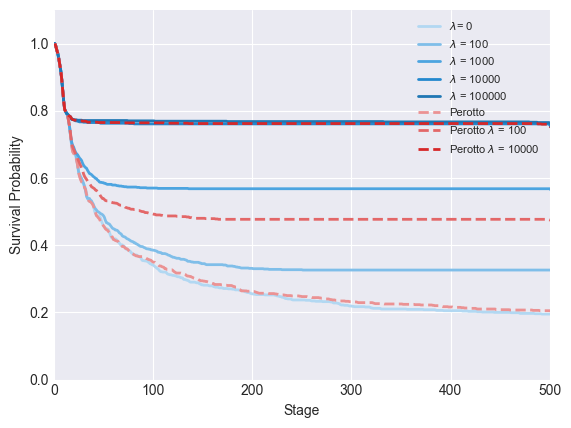

In [249]:
survivallam0 = np.zeros(nplays+1)
survivallam1 = np.zeros(nplays+1)
survivallam10 = np.zeros(nplays+1)
survivallam100 = np.zeros(nplays+1)
survivallam1000 = np.zeros(nplays+1)

survivalPerotto = np.zeros(nplays+1)
survivalPerotto1 = np.zeros(nplays+1)
survivalPerotto10 = np.zeros(nplays+1)

for i in range(nplays+1):
    survivallam0[i] = sum(Ntimeruinlam0 >= i+1)/len(Ntimeruinlam0)
    survivallam1[i] = sum(Ntimeruinlam1 >= i+1)/len(Ntimeruinlam1)
    survivallam10[i] = sum(Ntimeruinlam10 >= i+1)/len(Ntimeruinlam10)
    survivallam100[i] = sum(Ntimeruinlam100 >= i+1)/len(Ntimeruinlam100)
    survivallam1000[i] = sum(Ntimeruinlam1000 >= i+1)/len(Ntimeruinlam1000)
    survivalPerotto[i] = sum(NtimeruinPerotto >= i+1)/len(NtimeruinPerotto)
    survivalPerotto1[i] = sum(NtimeruinPerotto1 >= i+1)/len(NtimeruinPerotto10)
    survivalPerotto10[i] = sum(NtimeruinPerotto10 >= i+1)/len(NtimeruinPerotto10)
print(range(1, nplays + 1))
# Create the plot

plt.style.use('seaborn-v0_8-darkgrid')
plt.plot(range(1, nplays + 2), survivallam0, color=lighten_color('C0', 0.3), linestyle='-', label=fr'$\lambda$= 0', lw = 2)
plt.plot(range(1, nplays + 2), survivallam1, color=lighten_color('C0', 0.5), linestyle='-', label=fr'$\lambda$ = {lam1}', lw = 2)
plt.plot(range(1, nplays + 2), survivallam10, color=lighten_color('C0', 0.7), linestyle='-', label=fr'$\lambda$ = {lam2}', lw = 2)
plt.plot(range(1, nplays + 2), survivallam100, color=lighten_color('C0', 0.9), linestyle='-', label=fr'$\lambda$ = {lam3}', lw = 2)
plt.plot(range(1, nplays + 2), survivallam1000, color='C0', linestyle='-', label=fr'$\lambda$ = {lam4}', lw = 2)

plt.plot(range(1, nplays + 2), survivalPerotto, color=lighten_color('C3', 0.5), linestyle='--', label=fr'Perotto', lw = 2)
plt.plot(range(1, nplays + 2), survivalPerotto1, color=lighten_color('C3', 0.7), linestyle='--', label=fr'Perotto $\lambda$ = {lam1}', lw = 2)
plt.plot(range(1, nplays + 2), survivalPerotto10, color='C3', linestyle='--', label=fr'Perotto $\lambda$ = {lam3}', lw = 2)

# Add titles and labels
plt.xlabel('Stage')
plt.ylabel('Survival Probability')
# plt.title(f'Survival Curves standard UCB {aa} with {trials} simulations (Normal)')
plt.ylim(0, 1.1)
plt.xlim(0, 500)
# Add the legend
plt.legend(loc='upper right', prop = {'size':8})

# Show the plot
plt.show()

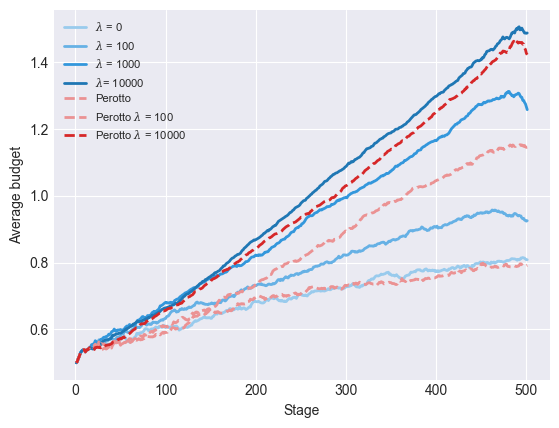

In [275]:
# Create the plot
plt.style.use('seaborn-v0_8-darkgrid')
plt.plot(range(1, nplays + 2), np.mean(Nbudgetlam0, axis = 0), color=lighten_color('C0', 0.4), linestyle='-', label=fr'$\lambda$ = 0',lw = 2)
plt.plot(range(1, nplays + 2), np.mean(Nbudgetlam1, axis = 0), color=lighten_color('C0', 0.6), linestyle='-', label=fr'$\lambda$ = {lam1}',lw = 2)
plt.plot(range(1, nplays + 2), np.mean(Nbudgetlam10, axis = 0), color=lighten_color('C0', 0.8), linestyle='-', label=fr'$\lambda$ = {lam2}',lw = 2)
plt.plot(range(1, nplays + 2), np.mean(Nbudgetlam100, axis = 0), color='C0', linestyle='-', label=fr'$\lambda$= {lam3}',lw = 2)
plt.plot(range(1, nplays + 2), np.mean(NbudgetPerotto, axis = 0), color=lighten_color('C3', 0.5), linestyle='--', label='Perotto',lw = 2)
plt.plot(range(1, nplays + 2), np.mean(NbudgetPerotto1, axis = 0), color=lighten_color('C3', 0.5), linestyle='--', label=fr'Perotto $\lambda$ = {lam1}',lw = 2)
plt.plot(range(1, nplays + 2), np.mean(NbudgetPerotto10, axis = 0), color='C3', linestyle='--', label=fr'Perotto $\lambda$ = {lam3}',lw = 2)

# Add titles and labels
plt.xlabel('Stage')
plt.ylabel('Average budget')
#plt.title(f'Average budget UCB {aa} with {trials} simulations (Normal)')

# Add the legend
plt.legend(loc='upper left', prop = {'size': 8})

# Show the plot
plt.show()

In [95]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['DejaVu Serif']
mpl.rcParams['mathtext.fontset'] = 'dejavuserif'

range(1, 501)


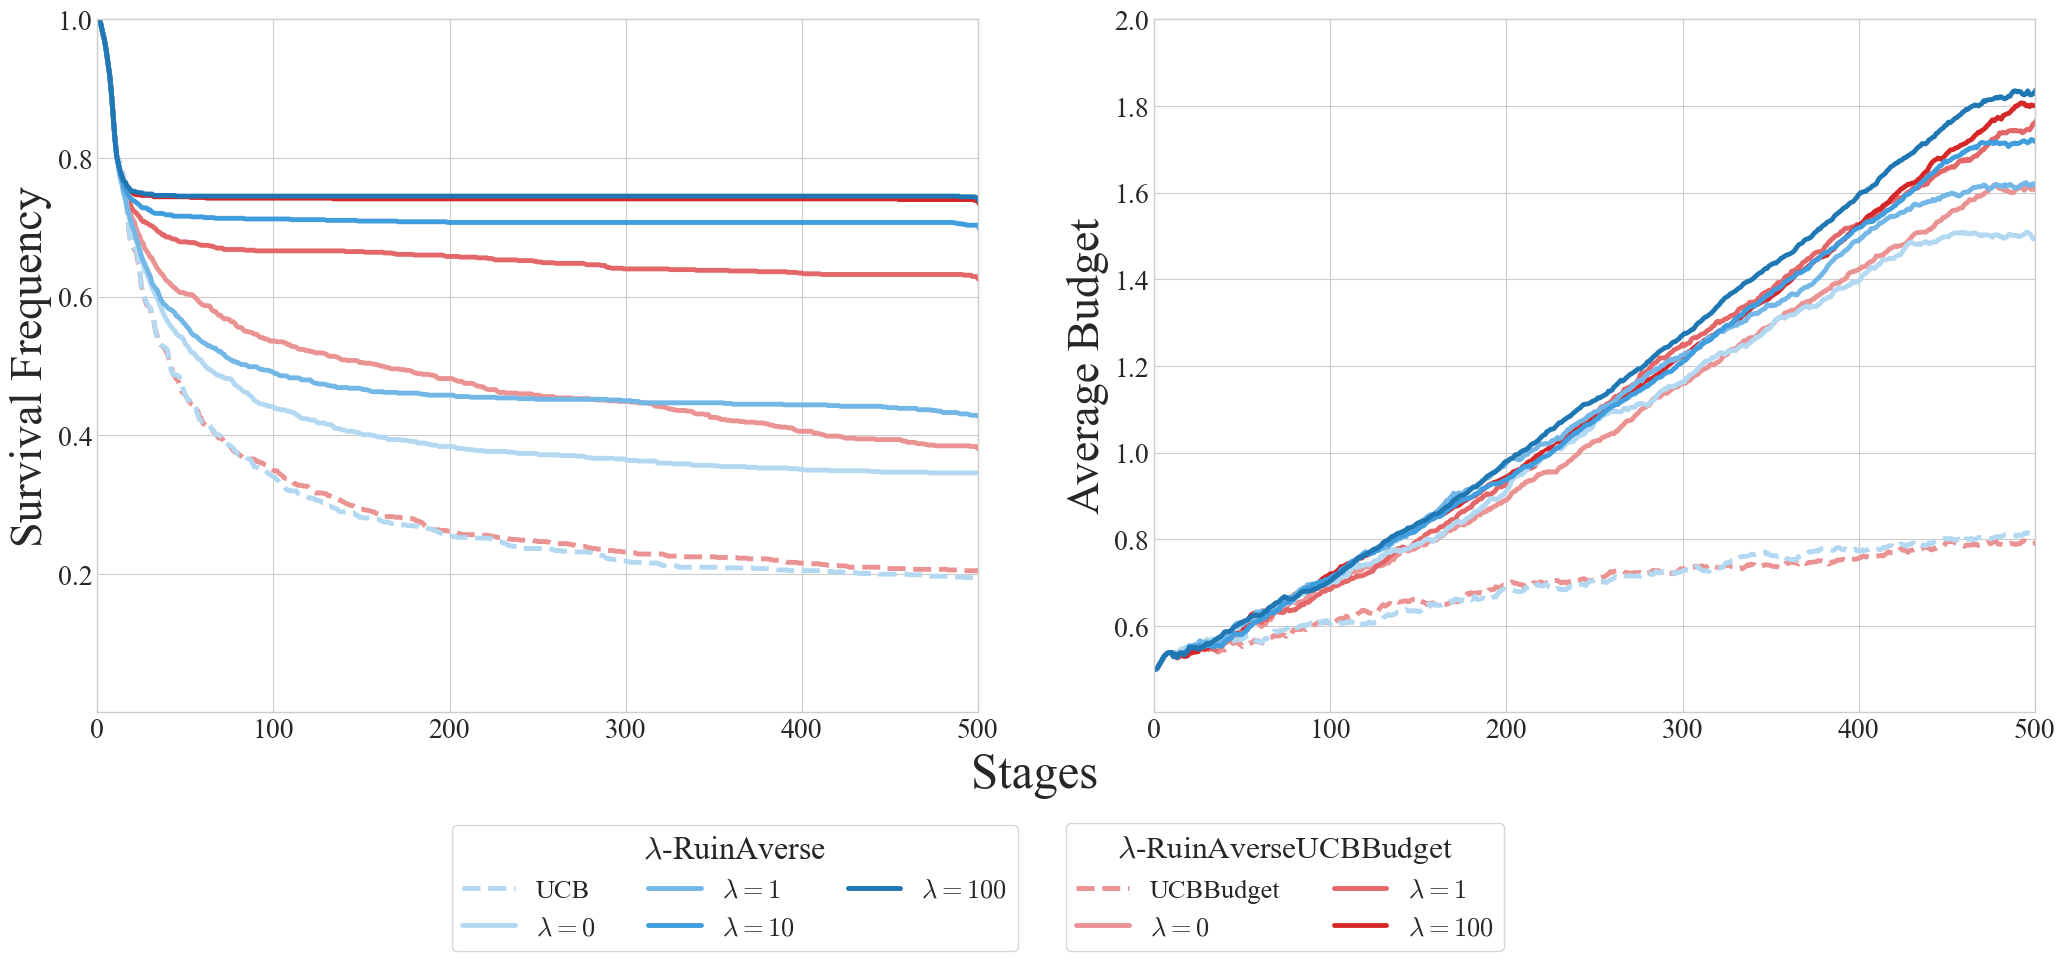

In [353]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # or 'Georgia', etc.
plt.rcParams['mathtext.fontset'] = 'cm'
survivallam0 = np.zeros(nplays+1)
survivallam1 = np.zeros(nplays+1)
survivallam10 = np.zeros(nplays+1)
survivallam100 = np.zeros(nplays+1)
survivallam1000 = np.zeros(nplays+1)
survivalPerotto = np.zeros(nplays+1)
survivalPerotto1 = np.zeros(nplays+1)
survivalPerotto10 = np.zeros(nplays+1)
survivalPerotto100 = np.zeros(nplays+1)

for i in range(nplays+1):
    survivallam0[i] = sum(Ntimeruinlam0 >= i+1)/len(Ntimeruinlam0)
    survivallam1[i] = sum(Ntimeruinlam1 >= i+1)/len(Ntimeruinlam1)
    survivallam10[i] = sum(Ntimeruinlam10 >= i+1)/len(Ntimeruinlam10)
    survivallam100[i] = sum(Ntimeruinlam100 >= i+1)/len(Ntimeruinlam100)
    survivallam1000[i] = sum(Ntimeruinlam1000 >= i+1)/len(Ntimeruinlam1000)
    survivalPerotto[i] = sum(NtimeruinPerotto >= i+1)/len(NtimeruinPerotto)
    survivalPerotto1[i] = sum(NtimeruinPerotto1 >= i+1)/len(NtimeruinPerotto10)
    survivalPerotto10[i] = sum(NtimeruinPerotto10 >= i+1)/len(NtimeruinPerotto10)
    survivalPerotto100[i] = sum(NtimeruinPerotto100 >= i+1)/len(NtimeruinPerotto100)
print(range(1, nplays + 1))
# Create the plot

fig, ax = plt.subplots(1, 2, figsize=(25, 9))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot 1: Survival Probability
x = range(1, nplays + 2)
linewidth = 3.5
line6, = ax[0].plot(x, survivalPerotto, color=lighten_color('C3', 0.5), linestyle='--', label='UCBBudget', lw=linewidth)
line7, = ax[0].plot(x, survivalPerotto1, color=lighten_color('C3', 0.5), linestyle='-', label=fr'$\lambda = 0$', lw=linewidth)
line8, = ax[0].plot(x, survivalPerotto10, color=lighten_color('C3', 0.7), linestyle='-', label=fr'$\lambda = {lam1}$', lw=linewidth)
line9, = ax[0].plot(x, survivalPerotto100, color='C3', linestyle='-', label=fr'$\lambda = {lam3}$', lw=linewidth)

line1, = ax[0].plot(x, survivallam0, color=lighten_color('C0', 0.3), linestyle='--', label=fr'UCB', lw=linewidth)
line2, = ax[0].plot(x, survivallam1, color=lighten_color('C0', 0.3), linestyle='-', label=fr'$\lambda = 0$', lw=linewidth)
line3, = ax[0].plot(x, survivallam10, color=lighten_color('C0', 0.55), linestyle='-', label=fr'$\lambda = {lam1}$', lw=linewidth)
line4, = ax[0].plot(x, survivallam100, color=lighten_color('C0', 0.75), linestyle='-', label=fr'$\lambda = {lam2}$', lw=linewidth)
line5, = ax[0].plot(x, survivallam1000, color='C0', linestyle='-', label=fr'$\lambda = {lam3}$', lw=linewidth)


xticks = np.array([0,100,200,300,400,500])
y1ticks = np.array([0,0.2,0.4,0.6,0.8,1])
ax[0].set_ylabel('Survival Frequency', fontsize = 33)
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks, fontsize = 20)
ax[0].set_yticks(y1ticks)
ax[0].set_yticklabels(y1ticks, fontsize = 20)


ax[0].set_ylim(0.001, 1)
ax[0].set_xlim(0, 500)

# Plot 2: Average Budget
ax[1].plot(range(1, nplays + 2), np.mean(NbudgetPerotto, axis=0), color=lighten_color('C3', 0.5), linestyle='--', label='Perotto', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(NbudgetPerotto1, axis=0), color=lighten_color('C3', 0.5), linestyle='-', label=fr'Perotto $\lambda$ = {lam1}', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(NbudgetPerotto10, axis=0), color=lighten_color('C3', 0.7), linestyle='-', label=fr'Perotto $\lambda$ = {lam3}', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(NbudgetPerotto100, axis=0), color='C3', linestyle='-', label=fr'Perotto $\lambda$ = {lam3}', lw=linewidth)


ax[1].plot(range(1, nplays + 2), np.mean(Nbudgetlam0, axis=0), color=lighten_color('C0', 0.3), linestyle='--', label=fr'UCB', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(Nbudgetlam1, axis=0), color=lighten_color('C0', 0.3), linestyle='-', label=fr'$\lambda$ = {lam1}', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(Nbudgetlam10, axis=0), color=lighten_color('C0', 0.55), linestyle='-', label=fr'$\lambda$ = {lam2}', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(Nbudgetlam100, axis=0), color=lighten_color('C0', 0.75), linestyle='-', label=fr'RuinAverse $\lambda$ = {lam3}', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(Nbudgetlam1000, axis=0), color='C0', linestyle='-', label=fr'RuinAverse$\lambda$= {lam4}', lw=linewidth)


y2ticks = np.array([0,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2])

ax[1].set_xlim(0, 500)
ax[1].set_ylabel('Average Budget',fontsize = 33)
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticks, fontsize = 20)

ax[1].set_yticks(y2ticks)
ax[1].set_yticklabels(y2ticks, fontsize = 20)

ax[1].set_ylim(0.401, 2)


# # Plot 3: Average Cumulative Regret
# ax[2].plot(range(1, nplays + 1), np.mean(Nregretlam0[Ntimeruinlam0 == 501,], axis=0), color=lighten_color('C0', 0.4), linestyle='-', label=fr'$\lambda$ = 0', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(Nregretlam1[Ntimeruinlam1 == 501,], axis=0), color=lighten_color('C0', 0.6), linestyle='-', label=fr'$\lambda$= {lam1}', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(Nregretlam10[Ntimeruinlam10 == 501,], axis=0), color=lighten_color('C0', 0.8), linestyle='-', label=fr'$\lambda$= {lam2}', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(Nregretlam100[Ntimeruinlam100 == 501,], axis=0), color='C0', linestyle='-', label=fr'$\lambda$ = {lam3}', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(NregretPerotto[NtimeruinPerotto == 501,], axis=0), color=lighten_color('C3', 0.5), linestyle='--', label='Perotto', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(NregretPerotto1[NtimeruinPerotto1 == 501,], axis=0), color=lighten_color('C3', 0.7), linestyle='--', label=fr'Perotto $\lambda$ = {lam1}', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(NregretPerotto10[NtimeruinPerotto10 == 501,], axis=0), color='C3', linestyle='--', label=fr'Perotto $\lambda$ = {lam3}', lw=2)
# ax[2].set_xlim(0, 500)
# ax[2].set_ylabel('Average Cumulative Regret',fontsize = 20)

# Add a global legend for the first subplot only
lines_legend1 = [line1, line2, line3, line4, line5]
labels_legend1 = [line1.get_label(), line2.get_label(), line3.get_label(), line4.get_label(), line5.get_label()]

lines_legend2 = [line6, line7, line8, line9]
labels_legend2 = [line6.get_label(), line7.get_label(), line8.get_label(), line9.get_label()]

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # or 'Georgia', etc.
plt.rcParams['mathtext.fontset'] = 'cm'
fig.legend(lines_legend1, labels_legend1, loc='lower center', bbox_to_anchor=(0.38, -0.17), ncol=3, title = fr'$\lambda$-RuinAverse', title_fontsize = 23, fontsize=19, frameon = True)
fig.legend(lines_legend2, labels_legend2, loc='lower center', bbox_to_anchor=(0.60, -0.17), ncol=2, title = fr'$\lambda$-RuinAverseUCBBudget', title_fontsize = 22.6, fontsize=19, frameon = True)

fig.text(0.5, 0.04, 'Stages', ha='center', va='center', fontsize=35)
#fig.legend(lines_first_subplot, labels_first_subplot, loc='lower center',bbox_to_anchor = (0.5,-0.13), ncol = 5, prop={'size': 22})

plt.show()

range(1, 501)


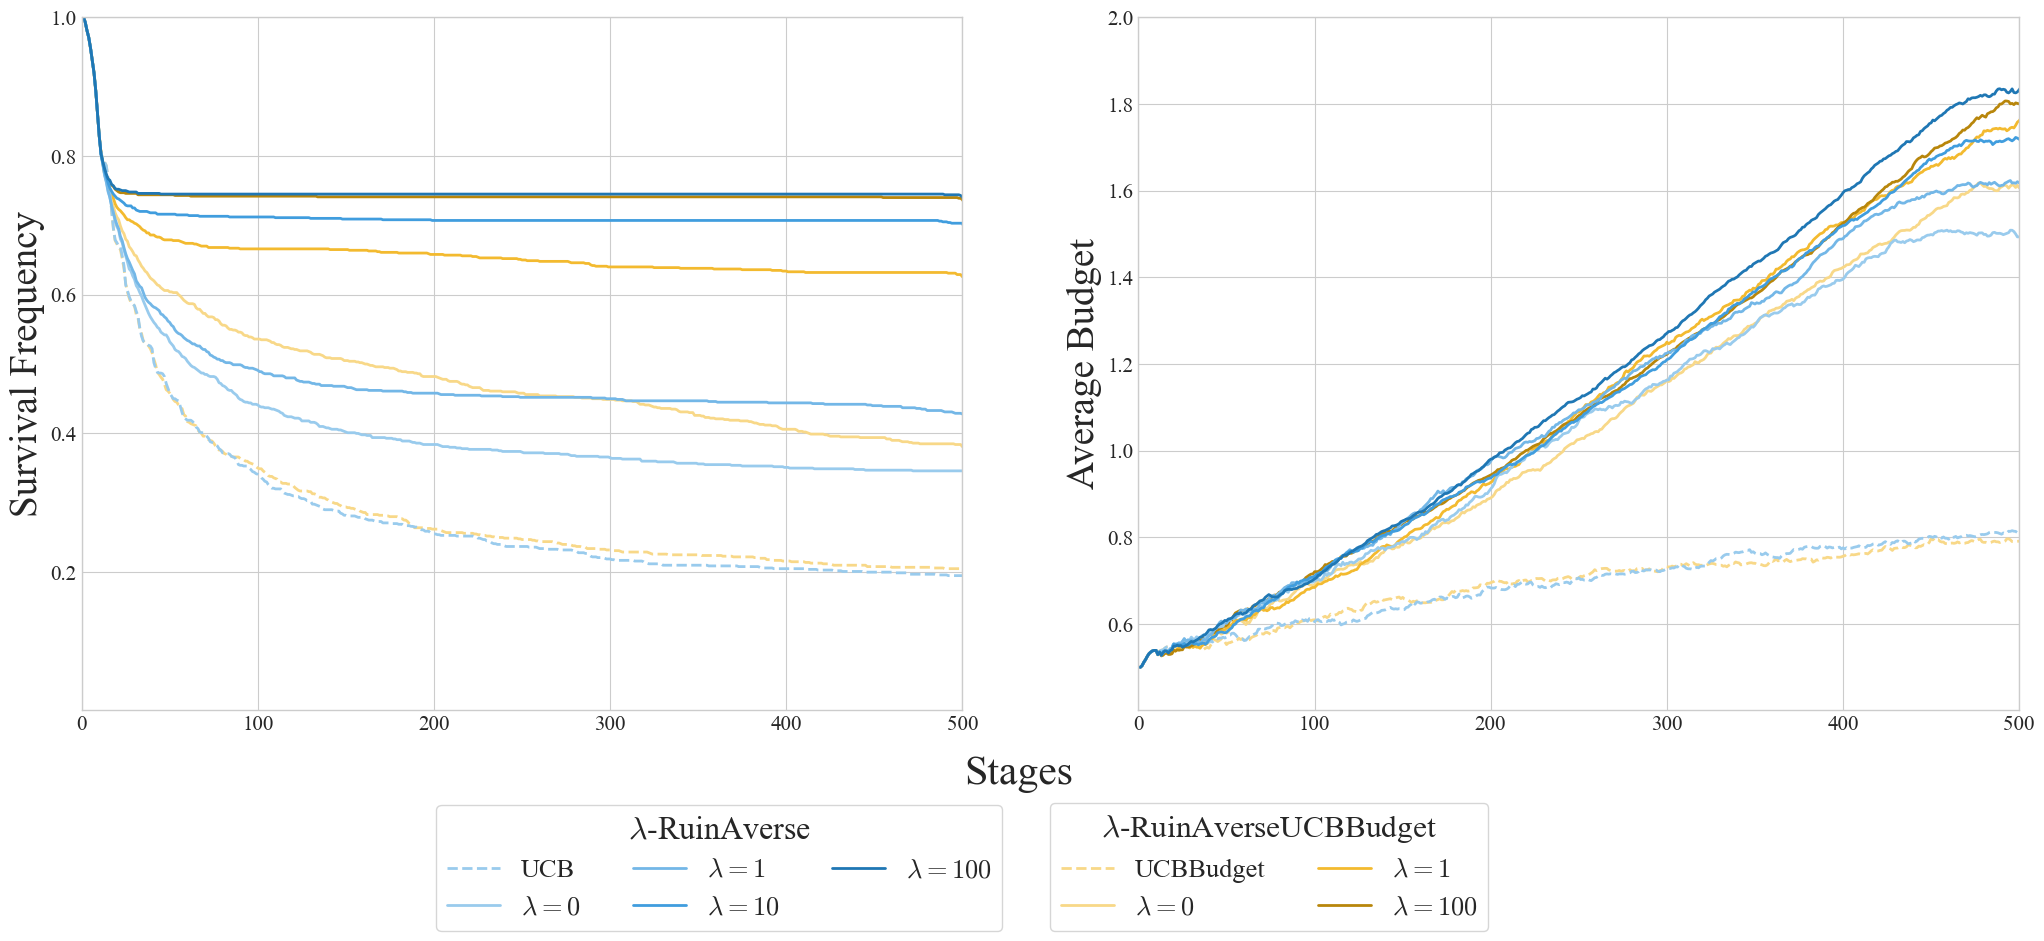

In [331]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # or 'Georgia', etc.
plt.rcParams['mathtext.fontset'] = 'cm'
survivallam0 = np.zeros(nplays+1)
survivallam1 = np.zeros(nplays+1)
survivallam10 = np.zeros(nplays+1)
survivallam100 = np.zeros(nplays+1)
survivallam1000 = np.zeros(nplays+1)
survivalPerotto = np.zeros(nplays+1)
survivalPerotto1 = np.zeros(nplays+1)
survivalPerotto10 = np.zeros(nplays+1)
survivalPerotto100 = np.zeros(nplays+1)

for i in range(nplays+1):
    survivallam0[i] = sum(Ntimeruinlam0 >= i+1)/len(Ntimeruinlam0)
    survivallam1[i] = sum(Ntimeruinlam1 >= i+1)/len(Ntimeruinlam1)
    survivallam10[i] = sum(Ntimeruinlam10 >= i+1)/len(Ntimeruinlam10)
    survivallam100[i] = sum(Ntimeruinlam100 >= i+1)/len(Ntimeruinlam100)
    survivallam1000[i] = sum(Ntimeruinlam1000 >= i+1)/len(Ntimeruinlam1000)
    survivalPerotto[i] = sum(NtimeruinPerotto >= i+1)/len(NtimeruinPerotto)
    survivalPerotto1[i] = sum(NtimeruinPerotto1 >= i+1)/len(NtimeruinPerotto10)
    survivalPerotto10[i] = sum(NtimeruinPerotto10 >= i+1)/len(NtimeruinPerotto10)
    survivalPerotto100[i] = sum(NtimeruinPerotto100 >= i+1)/len(NtimeruinPerotto100)
print(range(1, nplays + 1))
# Create the plot

fig, ax = plt.subplots(1, 2, figsize=(25, 9))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot 1: Survival Probability
x = range(1, nplays + 2)

csub = 'darkgoldenrod'
line6, = ax[0].plot(x, survivalPerotto, color=lighten_color(csub , 0.4), linestyle='--', label='UCBBudget', lw=2)
line7, = ax[0].plot(x, survivalPerotto1, color=lighten_color(csub , 0.4), linestyle='-', label=fr'$\lambda = 0$', lw=2)
line8, = ax[0].plot(x, survivalPerotto10, color=lighten_color(csub , 0.7), linestyle='-', label=fr'$\lambda = {lam1}$', lw=2)
line9, = ax[0].plot(x, survivalPerotto100, color=csub , linestyle='-', label=fr'$\lambda = {lam3}$', lw=2)

line1, = ax[0].plot(x, survivallam0, color=lighten_color('C0', 0.4), linestyle='--', label=fr'UCB', lw=2)
line2, = ax[0].plot(x, survivallam1, color=lighten_color('C0', 0.4), linestyle='-', label=fr'$\lambda = 0$', lw=2)
line3, = ax[0].plot(x, survivallam10, color=lighten_color('C0', 0.55), linestyle='-', label=fr'$\lambda = {lam1}$', lw=2)
line4, = ax[0].plot(x, survivallam100, color=lighten_color('C0', 0.75), linestyle='-', label=fr'$\lambda = {lam2}$', lw=2)
line5, = ax[0].plot(x, survivallam1000, color='C0', linestyle='-', label=fr'$\lambda = {lam3}$', lw=2)


xticks = np.array([0,100,200,300,400,500])
y1ticks = np.array([0,0.2,0.4,0.6,0.8,1])
ax[0].set_ylabel('Survival Frequency', fontsize = 28)
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks, fontsize = 15)
ax[0].set_yticks(y1ticks)
ax[0].set_yticklabels(y1ticks, fontsize = 15)


ax[0].set_ylim(0.001, 1)
ax[0].set_xlim(0, 500)

# Plot 2: Average Budget
ax[1].plot(range(1, nplays + 2), np.mean(NbudgetPerotto, axis=0), color=lighten_color(csub , 0.4), linestyle='--', label='Perotto', lw=2)
ax[1].plot(range(1, nplays + 2), np.mean(NbudgetPerotto1, axis=0), color=lighten_color(csub , 0.4), linestyle='-', label=fr'Perotto $\lambda$ = {lam1}', lw=2)
ax[1].plot(range(1, nplays + 2), np.mean(NbudgetPerotto10, axis=0), color=lighten_color(csub , 0.7), linestyle='-', label=fr'Perotto $\lambda$ = {lam3}', lw=2)
ax[1].plot(range(1, nplays + 2), np.mean(NbudgetPerotto100, axis=0), color=csub , linestyle='-', label=fr'Perotto $\lambda$ = {lam3}', lw=2)


ax[1].plot(range(1, nplays + 2), np.mean(Nbudgetlam0, axis=0), color=lighten_color('C0', 0.4), linestyle='--', label=fr'UCB', lw=2)
ax[1].plot(range(1, nplays + 2), np.mean(Nbudgetlam1, axis=0), color=lighten_color('C0', 0.4), linestyle='-', label=fr'RuinAverse $\lambda$ = {lam1}', lw=2)
ax[1].plot(range(1, nplays + 2), np.mean(Nbudgetlam10, axis=0), color=lighten_color('C0', 0.55), linestyle='-', label=fr'RuinAverse $\lambda$ = {lam2}', lw=2)
ax[1].plot(range(1, nplays + 2), np.mean(Nbudgetlam100, axis=0), color=lighten_color('C0', 0.75), linestyle='-', label=fr'RuinAverse $\lambda$ = {lam3}', lw=2)
ax[1].plot(range(1, nplays + 2), np.mean(Nbudgetlam1000, axis=0), color='C0', linestyle='-', label=fr'RuinAverse$\lambda$= {lam4}', lw=2)


y2ticks = np.array([0,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2])

ax[1].set_xlim(0, 500)
ax[1].set_ylabel('Average Budget',fontsize = 28)
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticks, fontsize = 15)

ax[1].set_yticks(y2ticks)
ax[1].set_yticklabels(y2ticks, fontsize = 15)

ax[1].set_ylim(0.401, 2)


# # Plot 3: Average Cumulative Regret
# ax[2].plot(range(1, nplays + 1), np.mean(Nregretlam0[Ntimeruinlam0 == 501,], axis=0), color=lighten_color('C0', 0.4), linestyle='-', label=fr'$\lambda$ = 0', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(Nregretlam1[Ntimeruinlam1 == 501,], axis=0), color=lighten_color('C0', 0.6), linestyle='-', label=fr'$\lambda$= {lam1}', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(Nregretlam10[Ntimeruinlam10 == 501,], axis=0), color=lighten_color('C0', 0.8), linestyle='-', label=fr'$\lambda$= {lam2}', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(Nregretlam100[Ntimeruinlam100 == 501,], axis=0), color='C0', linestyle='-', label=fr'$\lambda$ = {lam3}', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(NregretPerotto[NtimeruinPerotto == 501,], axis=0), color=lighten_color('C3', 0.5), linestyle='--', label='Perotto', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(NregretPerotto1[NtimeruinPerotto1 == 501,], axis=0), color=lighten_color('C3', 0.7), linestyle='--', label=fr'Perotto $\lambda$ = {lam1}', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(NregretPerotto10[NtimeruinPerotto10 == 501,], axis=0), color='C3', linestyle='--', label=fr'Perotto $\lambda$ = {lam3}', lw=2)
# ax[2].set_xlim(0, 500)
# ax[2].set_ylabel('Average Cumulative Regret',fontsize = 20)

# Add a global legend for the first subplot only
lines_legend1 = [line1, line2, line3, line4, line5]
labels_legend1 = [line1.get_label(), line2.get_label(), line3.get_label(), line4.get_label(), line5.get_label()]

lines_legend2 = [line6, line7, line8, line9]
labels_legend2 = [line6.get_label(), line7.get_label(), line8.get_label(), line9.get_label()]

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # or 'Georgia', etc.
plt.rcParams['mathtext.fontset'] = 'cm'
fig.legend(lines_legend1, labels_legend1, loc='lower center', bbox_to_anchor=(0.38, -0.15), ncol=3, title = fr'$\lambda$-RuinAverse', title_fontsize = 23, fontsize=19, frameon = True)
fig.legend(lines_legend2, labels_legend2, loc='lower center', bbox_to_anchor=(0.60, -0.15), ncol=2, title = fr'$\lambda$-RuinAverseUCBBudget', title_fontsize = 22.6, fontsize=19, frameon = True)

fig.text(0.5, 0.04, 'Stages', ha='center', va='center', fontsize=30)
plt.show()

In [179]:
### TO CSV ###
RuinTimeVec = np.stack((Ntimeruinlam0,Ntimeruinlam1,Ntimeruinlam10,Ntimeruinlam100,Ntimeruinlam1000,NtimeruinPerotto,NtimeruinPerotto1,NtimeruinPerotto10), axis = 0)
RuinTimeVecDF = pd.DataFrame(RuinTimeVec)
RuinTimeVecDF.to_csv("RuinTimeN8.csv")
BudgetVec = np.stack((np.mean(Nbudgetlam0, axis = 0), 
                      np.mean(Nbudgetlam1, axis = 0), 
                      np.mean(Nbudgetlam10, axis = 0), 
                      np.mean(Nbudgetlam100, axis = 0),
                      np.mean(Nbudgetlam1000, axis = 0),
                      np.mean(NbudgetPerotto, axis = 0),
                      np.mean(NbudgetPerotto1, axis = 0),
                      np.mean(NbudgetPerotto10, axis = 0)), axis = 0)
BudgetVecDF = pd.DataFrame(BudgetVec)
BudgetVecDF.to_csv("BudgetN8.csv")

# RegretVec = np.stack((np.mean(regretlam0[timeruinlam0 == 501,], axis = 0),
#                       np.mean(regretlam1[timeruinlam1 == 501,], axis = 0),
#                       np.mean(regretlam10[timeruinlam10 == 501,], axis = 0),
#                       np.mean(regretlam100[timeruinlam100 == 501,], axis = 0),
#                       np.mean(regretPerotto[timeruinPerotto == 501,], axis = 0),
#                       np.mean(regretPerotto1[timeruinPerotto1== 501,], axis = 0),
#                       np.mean(regretPerotto10[timeruinPerotto10 == 501,], axis = 0)), axis = 0)
# RegretVecDF = pd.DataFrame(RegretVec)
# RegretVecDF.to_csv("RegretN8S1.csv")

## Frontier

In [311]:
lam1 = 1000000
lam2 = 10000000
# lam3 = 1000000
# lam4 = 1000000

trials = 1000
seedoffset = 321

Ntimeruinlamlarge = np.zeros(trials)
Nbudgetlamlarge = np.zeros((trials,nplays+1))

Ntimeruinlamxlarge = np.zeros(trials)
Nbudgetlamxlarge = np.zeros((trials,nplays+1))

# Ntimeruinlam10 = np.zeros(trials)
# Nbudgetlam10 = np.zeros((trials,nplays+1))

# Ntimeruinlam100 = np.zeros(trials)
# Nbudgetlam100 = np.zeros((trials,nplays+1))

# Ntimeruinlam1000 = np.zeros(trials)
# Nbudgetlam1000 = np.zeros((trials,nplays+1))


# NtimeruinPerotto = np.zeros(trials)
# NbudgetPerotto = np.zeros((trials,nplays+1))

# NtimeruinPerotto1 = np.zeros(trials)
# NbudgetPerotto1 = np.zeros((trials,nplays+1))

# NtimeruinPerotto10 = np.zeros(trials)
# NbudgetPerotto10 = np.zeros((trials,nplays+1))

for i in range(trials):
    start = time.time()

    Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin = simulate_bandit(k, aa, nplays, b0, lam1, M, arm_n,i+seedoffset)
    Ntimeruinlamlarge[i] = timeRuin 
    Nbudgetlamlarge[i,:] = budget
    # if(isRuined == False): 
    #     Nregretlam0[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))

    Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit(k, aa, nplays, b0, lam2, M, arm_n,i+seedoffset)
    Ntimeruinlamxlarge[i] = timeRuin 
    Nbudgetlamxlarge[i,:] = budget
    # if(isRuined == False): 
    #     Nregretlam1[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))

    # Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit(k, aa, nplays, b0, lam2, M, arm_n,i+seedoffset)
    # Ntimeruinlam10[i] = timeRuin 
    # Nbudgetlam10[i,:] = budget
    # # if(isRuined == False): 
    # #     Nregretlam10[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))
    
    # Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit(k, aa, nplays, b0, lam3, M, arm_n,i+seedoffset)
    # Ntimeruinlam100[i] = timeRuin 
    # Nbudgetlam100[i,:] = budget
    # # if(isRuined == False): 
    # #     Nregretlam100[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))

    # Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit_Perotto(k, aa, nplays, b0, lam4, M, arm_n,i+seedoffset)
    # Ntimeruinlam1000[i] = timeRuin 
    # Nbudgetlam1000[i,:] = budget
    # # if(isRuined == False):
    # #     NregretPerotto[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))

    # Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit_Perotto(k, aa, nplays, b0, 0, M, arm_n,i+seedoffset)
    # NtimeruinPerotto[i] = timeRuin 
    # NbudgetPerotto[i,:] = budget
    # # if(isRuined == False):
    # #     NregretPerotto[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))
    
    # Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit_Perotto(k, aa, nplays, b0, lam1, M, arm_n,i+seedoffset)
    # NtimeruinPerotto1[i] = timeRuin 
    # NbudgetPerotto1[i,:] = budget
    # # if(isRuined ==  False):
    # #     NregretPerotto1[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))

    # Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit_Perotto(k, aa, nplays, b0, lam3, M, arm_n,i+seedoffset)
    # NtimeruinPerotto10[i] = timeRuin 
    # NbudgetPerotto10[i,:] = budget
    # # if(isRuined ==  False):
    # #     NregretPerotto10[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))
    
    end = time.time()
    print(f'The {i+1}-th iteration took {end-start:1f} to run')

The 1-th iteration took 2.983855 to run
The 2-th iteration took 3.301590 to run
The 3-th iteration took 0.006640 to run
The 4-th iteration took 3.609555 to run
The 5-th iteration took 3.747624 to run
The 6-th iteration took 4.902593 to run
The 7-th iteration took 4.109814 to run
The 8-th iteration took 3.103791 to run
The 9-th iteration took 0.005128 to run
The 10-th iteration took 4.168014 to run
The 11-th iteration took 0.042236 to run
The 12-th iteration took 5.183540 to run
The 13-th iteration took 5.116274 to run
The 14-th iteration took 5.333374 to run
The 15-th iteration took 3.867007 to run
The 16-th iteration took 3.826865 to run
The 17-th iteration took 3.296296 to run
The 18-th iteration took 3.771789 to run
The 19-th iteration took 4.129009 to run
The 20-th iteration took 0.009008 to run
The 21-th iteration took 4.007900 to run
The 22-th iteration took 3.466591 to run
The 23-th iteration took 4.084210 to run
The 24-th iteration took 3.391189 to run
The 25-th iteration took 

In [312]:
print(sum(Ntimeruinlamlarge == (nplays +1))/trials)
print(sum(Ntimeruinlamxlarge == (nplays +1))/trials)
print(np.mean(Nbudgetlamlarge[:,500]))
print(np.mean(Nbudgetlamxlarge[:,500]))

0.757
0.757
1.5034239845205237
1.5034239845205237


In [44]:
lambdavec = np.concatenate((np.array([0, 1, 2, 3, 4]), np.linspace(5, 100, num=20)))

25

In [99]:
nplays = 500
aa = 10
b0 = 0.5
M = 100
cons = 0.1
k = 8

np.random.seed(12345)
muvec =  np.random.uniform(-0.01,0.01 ,size = 8)
sigvec =  np.random.gamma(shape = 1, scale = 0.1,size = 8)
k = len(muvec)

lambdavec = np.concatenate((np.array([0, 1, 2, 3, 4]), np.linspace(5, 100, num=20)))
trials = 1000
offset = 100

SurvivalProb = np.zeros(len(lambdavec))
AverageBudget = np.zeros(len(lambdavec))

for j in range(len(lambdavec)):
    numRuined = np.zeros(trials)
    numBudget = np.zeros(trials)
    for i in range(trials):
        start = time.time()
        Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin = simulate_bandit(k, aa, nplays, b0, lambdavec[j], M, arm_n,i+offset)
        numRuined[i] = isRuined
        numBudget[i] = budget[nplays]
        end = time.time()
        print(f'For lam = {lambdavec[j]} the {i+1}-th iteration took {end-start:1f} to run')
    SurvivalProb[j] = 1 - np.mean(numRuined)
    AverageBudget[j] = np.mean(numBudget)

For lam = 0.0 the 1-th iteration took 0.987385 to run
For lam = 0.0 the 2-th iteration took 1.430086 to run
For lam = 0.0 the 3-th iteration took 0.000000 to run
For lam = 0.0 the 4-th iteration took 1.320204 to run
For lam = 0.0 the 5-th iteration took 1.230421 to run
For lam = 0.0 the 6-th iteration took 1.452238 to run
For lam = 0.0 the 7-th iteration took 1.136936 to run
For lam = 0.0 the 8-th iteration took 0.118411 to run
For lam = 0.0 the 9-th iteration took 1.179136 to run
For lam = 0.0 the 10-th iteration took 0.219843 to run
For lam = 0.0 the 11-th iteration took 1.450061 to run
For lam = 0.0 the 12-th iteration took 0.000000 to run
For lam = 0.0 the 13-th iteration took 1.387131 to run
For lam = 0.0 the 14-th iteration took 0.039995 to run
For lam = 0.0 the 15-th iteration took 0.419715 to run
For lam = 0.0 the 16-th iteration took 1.146116 to run
For lam = 0.0 the 17-th iteration took 1.269674 to run
For lam = 0.0 the 18-th iteration took 0.401816 to run
For lam = 0.0 the 1

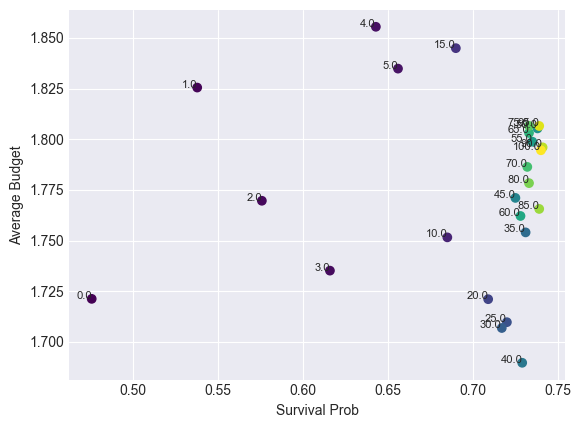

In [107]:
plt.scatter(SurvivalProb,AverageBudget, c = lambdavec, cmap = 'viridis')
plt.xlabel('Survival Prob')
plt.ylabel('Average Budget')
# plt.xlim(0.7,0.75)
for i in range(len(lambdavec)):
    plt.text(SurvivalProb[i],AverageBudget[i], f'{lambdavec[i]:}', fontsize=8, ha='right')

## 8 Normal 1 safe

In [ ]:
nplays = 500
aa = 10
b0 = 0.5
M = 100
cons = 0.1

# np.random.seed(123)
# muvec = np.random.uniform(-0.01,0.01 ,size = 8)
# sigvec = np.random.uniform(0.25,0.5,size = 8)
# k = len(muvec)



# muvec = np.array([-0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03, 0.05])
# sigvec = np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.5, 1]) ####gamma dist
# k = len(muvec)

# np.random.seed(123)
# muvec =  np.random.uniform(-0.25,0.25 ,size = 8)
# sigvec = np.zeros(8)
# for i in range(len(muvec)):
#     sigvec[i] = np.random.gamma(shape = np.abs(muvec[i]), scale = 10,size = 1)

np.random.seed(12345)
muvec =  np.random.uniform(-0.01,0.01 ,size = 8)
sigvec =  np.random.gamma(shape = 1, scale = 0.1,size = 8)
k = len(muvec) + 1


print(muvec)
print(sigvec)



[ 0.00859 -0.00367 -0.00632 -0.00591  0.00135  0.00191  0.00929  0.00306]
[0.13819 0.10601 0.13772 0.32521 0.00084 0.01125 0.03548 0.10683]


In [ ]:
def arm_e(n):
    if n < k:
        return np.random.normal(muvec[n-1],sigvec[n-1])
    elif n == k:
        return np.random.exponential(scale = 0.001)

In [29]:
start = time.time()
Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timer = simulate_bandit(k, aa, nplays, b0, 0, M, arm_e,223323)
end = time.time()
timer

501

In [ ]:
lam1 = 5
lam2 = 50
lam3 = 100

trials = 1000
offset = 100

timeruinlam0 = np.zeros(trials)
budgetlam0 = np.zeros((trials,nplays+1))
regretlam0 = np.zeros((trials,nplays))

timeruinlam1 = np.zeros(trials)
budgetlam1 = np.zeros((trials,nplays+1))
regretlam1 = np.zeros((trials,nplays))

timeruinlam10 = np.zeros(trials)
budgetlam10 = np.zeros((trials,nplays+1))
regretlam10 = np.zeros((trials,nplays))

timeruinlam100 = np.zeros(trials)
budgetlam100 = np.zeros((trials,nplays+1))
regretlam100 = np.zeros((trials,nplays))

timeruinPerotto = np.zeros(trials)
budgetPerotto = np.zeros((trials,nplays+1))
regretPerotto = np.zeros((trials,nplays))

timeruinPerotto1 = np.zeros(trials)
budgetPerotto1 = np.zeros((trials,nplays+1))
regretPerotto1 = np.zeros((trials,nplays))

timeruinPerotto10 = np.zeros(trials)
budgetPerotto10 = np.zeros((trials,nplays+1))
regretPerotto10 = np.zeros((trials,nplays))

for i in range(trials):
    start = time.time()
    Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin = simulate_bandit(k, aa, nplays, b0, 0, M, arm_e,i+offset)
    timeruinlam0[i] = timeRuin 
    budgetlam0[i,:] = budget
    # if(isRuined == False): 
    #     regretlam0[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))

    Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit(k, aa, nplays, b0, lam1, M, arm_e,i+offset)
    timeruinlam1[i] = timeRuin 
    budgetlam1[i,:] = budget
    # if(isRuined == False): 
    #     regretlam1[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))

    Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit(k, aa, nplays, b0, lam2, M, arm_e,i+offset)
    timeruinlam10[i] = timeRuin 
    budgetlam10[i,:] = budget
    # if(isRuined == False): 
    #     regretlam10[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))

    Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit(k, aa, nplays, b0, lam3, M, arm_e,i+offset)
    timeruinlam100[i] = timeRuin 
    budgetlam100[i,:] = budget
    # if(isRuined == False): 
    #     regretlam100[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))


    Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit_Perotto(k, aa, nplays, b0, 0, M, arm_e,i+offset)
    timeruinPerotto[i] = timeRuin 
    budgetPerotto[i,:] = budget
    # if(isRuined == False): 
    #     regretPerotto[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))
    
    Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit_Perotto(k, aa, nplays, b0, lam1, M, arm_e,i+offset)
    timeruinPerotto1[i] = timeRuin 
    budgetPerotto1[i,:] = budget
    # if(isRuined == False): 
    #     regretPerotto1[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))

    Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit_Perotto(k, aa, nplays, b0, lam3, M, arm_e,i+offset)
    timeruinPerotto10[i] = timeRuin 
    budgetPerotto10[i,:] = budget
    # if(isRuined == False): 
    #     regretPerotto10[i,:] = np.cumsum(stageregret(ActionVec,nplays, 1, muvec,sigvec,100,k))

    end = time.time()
    print(f'The {i+1}-th iteration took {end-start:1f} to run')

The 1-th iteration took 11.652492 to run
The 2-th iteration took 11.516175 to run
The 3-th iteration took 0.249067 to run
The 4-th iteration took 10.345509 to run
The 5-th iteration took 0.088582 to run
The 6-th iteration took 8.635242 to run
The 7-th iteration took 0.015683 to run
The 8-th iteration took 10.280559 to run
The 9-th iteration took 9.166051 to run
The 10-th iteration took 8.962260 to run
The 11-th iteration took 8.495342 to run
The 12-th iteration took 0.015734 to run
The 13-th iteration took 8.333743 to run
The 14-th iteration took 7.166019 to run
The 15-th iteration took 5.880846 to run
The 16-th iteration took 8.100465 to run
The 17-th iteration took 7.300382 to run
The 18-th iteration took 8.436294 to run
The 19-th iteration took 8.667493 to run
The 20-th iteration took 0.000000 to run
The 21-th iteration took 0.115213 to run
The 22-th iteration took 7.729234 to run
The 23-th iteration took 6.853446 to run
The 24-th iteration took 7.020319 to run
The 25-th iteration t

In [30]:
print(sum(timeruinlam0 == (nplays +1))/trials)
print(sum(timeruinlam1 == (nplays +1))/trials)
print(sum(timeruinlam10 == (nplays +1))/trials)
print(sum(timeruinlam100 == (nplays +1))/trials)
print(sum(timeruinPerotto == (nplays +1))/trials)
print(sum(timeruinPerotto1 == (nplays +1))/trials)
print(sum(timeruinPerotto10 == (nplays +1))/trials)

0.46
0.648
0.746
0.748
0.537
0.663
0.757


range(1, 501)


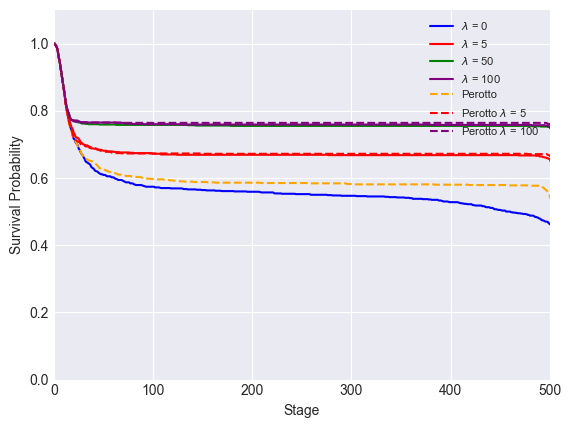

In [31]:
survivallam0 = np.zeros(nplays+1)
survivallam1 = np.zeros(nplays+1)
survivallam10 = np.zeros(nplays+1)
survivallam100 = np.zeros(nplays+1)
survivalPerotto = np.zeros(nplays+1)
survivalPerotto1 = np.zeros(nplays+1)
survivalPerotto10 = np.zeros(nplays+1)

for i in range(nplays+1):
    survivallam0[i] = sum(timeruinlam0 >= i+1)/len(timeruinlam0)
    survivallam1[i] = sum(timeruinlam1 >= i+1)/len(timeruinlam1)
    survivallam10[i] = sum(timeruinlam10 >= i+1)/len(timeruinlam10)
    survivallam100[i] = sum(timeruinlam100 >= i+1)/len(timeruinlam100)
    survivalPerotto[i] = sum(timeruinPerotto >= i+1)/len(timeruinPerotto)
    survivalPerotto1[i] = sum(timeruinPerotto1 >= i+1)/len(timeruinPerotto10)
    survivalPerotto10[i] = sum(timeruinPerotto10 >= i+1)/len(timeruinPerotto10)
print(range(1, nplays + 1))
# Create the plot
plt.plot(range(1, nplays + 2), survivallam0, color='blue', linestyle='-', label=fr'$\lambda$ = 0')
plt.plot(range(1, nplays + 2), survivallam1, color='red', linestyle='-', label=fr'$\lambda$ = {lam1}')
plt.plot(range(1, nplays + 2), survivallam10, color='green', linestyle='-', label=fr'$\lambda$ = {lam2}')
plt.plot(range(1, nplays + 2), survivallam100, color='purple', linestyle='-', label=fr'$\lambda$ = {lam3}')

plt.plot(range(1, nplays + 2), survivalPerotto, color='orange', linestyle='--', label=fr'Perotto')
plt.plot(range(1, nplays + 2), survivalPerotto1, color='red', linestyle='--', label=fr'Perotto $\lambda$ = {lam1}')
plt.plot(range(1, nplays + 2), survivalPerotto10, color='purple', linestyle='--', label=fr'Perotto $\lambda$ = {lam3}')

# Add titles and labels
plt.xlabel('Stage')
plt.ylabel('Survival Probability')
#plt.title(f'Survival Curves standard UCB {aa} with {trials} simulations (Normal)')
plt.ylim(0, 1.1)
plt.xlim(0, 500)
# Add the legend
plt.legend(loc='upper right', prop = {'size': 8})

# Show the plot
plt.show()

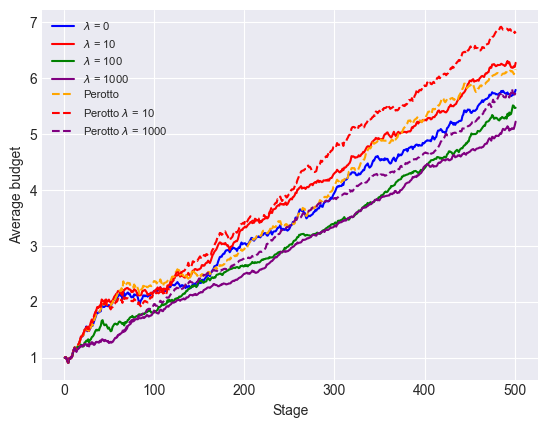

In [143]:
# Create the plot
plt.plot(range(1, nplays + 2), np.mean(budgetlam0, axis = 0), color='blue', linestyle='-', label=fr'$\lambda$ = 0')
plt.plot(range(1, nplays + 2), np.mean(budgetlam1, axis = 0), color='red', linestyle='-', label=fr'$\lambda$ = {lam1}')
plt.plot(range(1, nplays + 2), np.mean(budgetlam10, axis = 0), color='green', linestyle='-', label=fr'$\lambda$ = {lam2}')
plt.plot(range(1, nplays + 2), np.mean(budgetlam100, axis = 0), color='purple', linestyle='-', label=fr'$\lambda$ = {lam3}')
plt.plot(range(1, nplays + 2), np.mean(budgetPerotto, axis = 0), color='orange', linestyle='--', label='Perotto')
plt.plot(range(1, nplays + 2), np.mean(budgetPerotto1, axis = 0), color='red', linestyle='--', label=fr'Perotto $\lambda$ = {lam1}')
plt.plot(range(1, nplays + 2), np.mean(budgetPerotto10, axis = 0), color='purple', linestyle='--', label=fr'Perotto $\lambda$ = {lam3}')

# Add titles and labels
plt.xlabel('Stage')
plt.ylabel('Average budget')
# plt.title(f'Average budget UCB {aa} with {trials} simulations (Normal)')

# Add the legend
plt.legend(loc='upper left', prop = {'size': 8})

# Show the plot
plt.show()

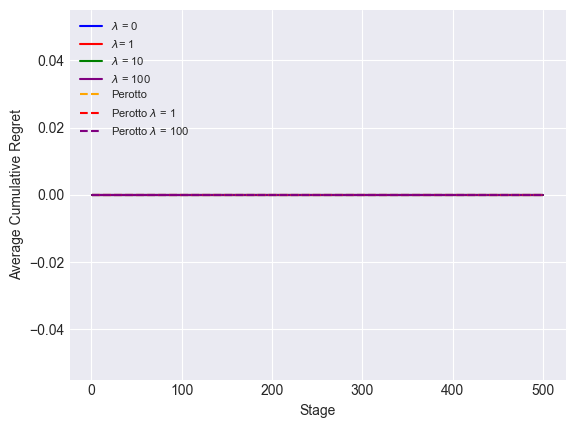

In [311]:
# Create the plot
plt.plot(range(1, nplays + 1), np.mean(regretlam0[timeruinlam0 == 501,], axis = 0), color='blue', linestyle='-', label=fr'$\lambda$ = 0')
plt.plot(range(1, nplays + 1), np.mean(regretlam1[timeruinlam1 == 501,], axis = 0), color='red', linestyle='-', label=fr'$\lambda$= {lam1}')
plt.plot(range(1, nplays + 1), np.mean(regretlam10[timeruinlam10 == 501,], axis = 0), color='green', linestyle='-', label=fr'$\lambda$ = {lam2}')
plt.plot(range(1, nplays + 1), np.mean(regretlam100[timeruinlam100 == 501,], axis = 0), color='purple', linestyle='-', label=fr'$\lambda$ = {lam3}')
plt.plot(range(1, nplays + 1), np.mean(regretPerotto[timeruinPerotto == 501,], axis = 0), color='orange', linestyle='--', label='Perotto')
plt.plot(range(1, nplays + 1), np.mean(regretPerotto1[timeruinPerotto1 == 501,], axis = 0), color='red', linestyle='--', label=fr'Perotto $\lambda$ = {lam1}')
plt.plot(range(1, nplays + 1), np.mean(regretPerotto10[timeruinPerotto10 == 501,], axis = 0), color='purple', linestyle='--', label=fr'Perotto $\lambda$ = {lam3}')

# Add titles and labels
plt.xlabel('Stage')
plt.ylabel('Average Cumulative Regret')
#plt.title(f'Average Cumulative Regret from non-ruined UCB {aa} with {trials} simulations (Normal)')

# Add the legend
plt.legend(loc='upper left', prop = {'size': 8})

# Show the plot
plt.show()

range(1, 501)


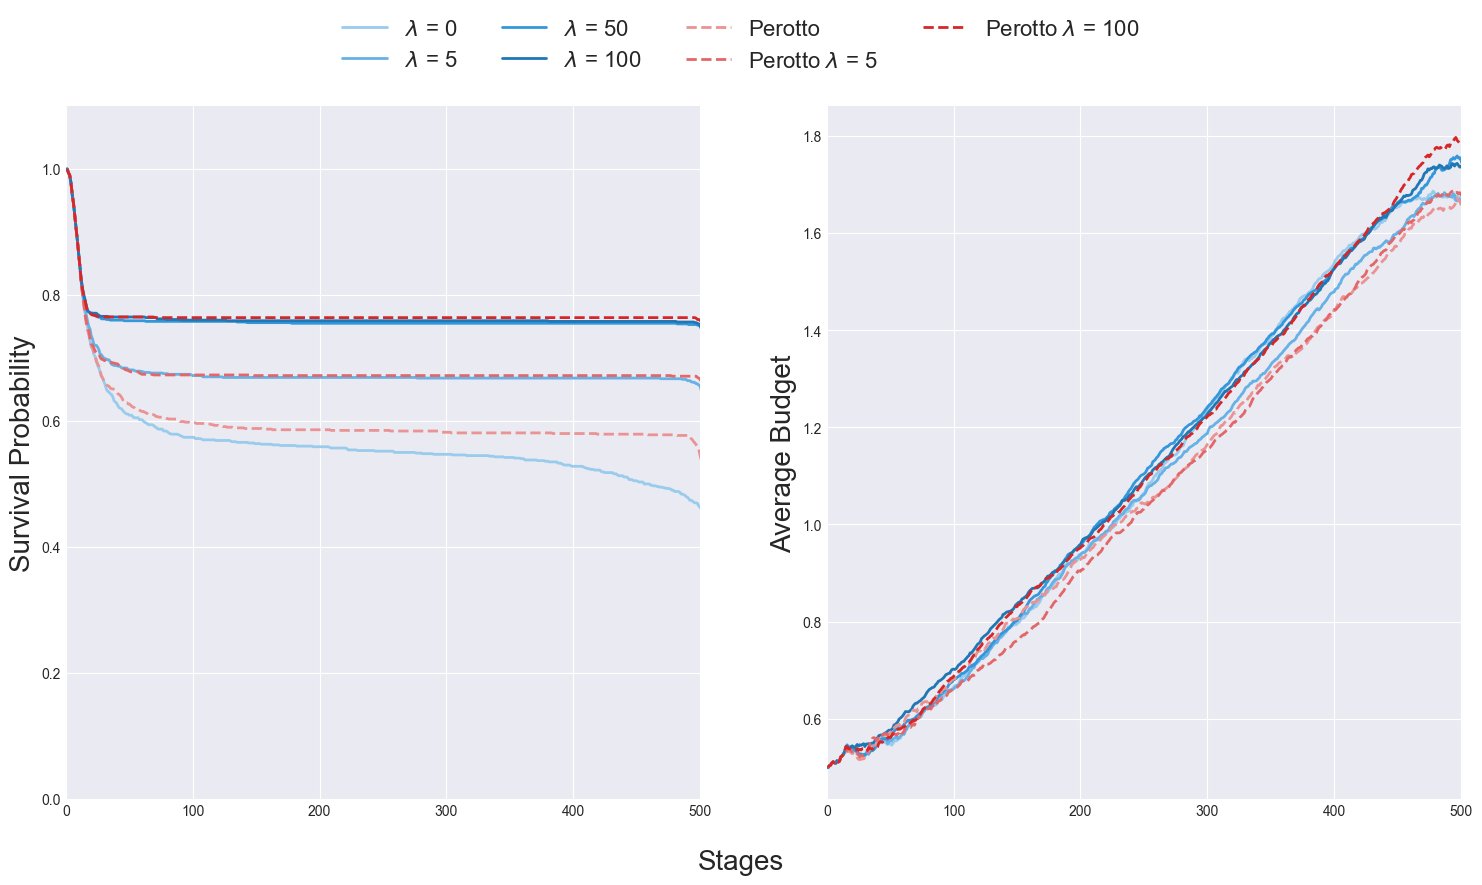

In [97]:
survivallam0 = np.zeros(nplays+1)
survivallam1 = np.zeros(nplays+1)
survivallam10 = np.zeros(nplays+1)
survivallam100 = np.zeros(nplays+1)
survivalPerotto = np.zeros(nplays+1)
survivalPerotto1 = np.zeros(nplays+1)
survivalPerotto10 = np.zeros(nplays+1)

for i in range(nplays+1):
    survivallam0[i] = sum(timeruinlam0 >= i+1)/len(timeruinlam0)
    survivallam1[i] = sum(timeruinlam1 >= i+1)/len(timeruinlam1)
    survivallam10[i] = sum(timeruinlam10 >= i+1)/len(timeruinlam10)
    survivallam100[i] = sum(timeruinlam100 >= i+1)/len(timeruinlam100)
    survivalPerotto[i] = sum(timeruinPerotto >= i+1)/len(timeruinPerotto)
    survivalPerotto1[i] = sum(timeruinPerotto1 >= i+1)/len(timeruinPerotto10)
    survivalPerotto10[i] = sum(timeruinPerotto10 >= i+1)/len(timeruinPerotto10)

print(range(1, nplays + 1))

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(18, 9))
plt.style.use('seaborn-v0_8-darkgrid')

# Plot 1: Survival Probability
line1, = ax[0].plot(range(1, nplays + 2), survivallam0, color=lighten_color('C0', 0.4), linestyle='-', label=fr'$\lambda$ = 0', lw=2)
line2, = ax[0].plot(range(1, nplays + 2), survivallam1, color=lighten_color('C0', 0.6), linestyle='-', label=fr'$\lambda$ = {lam1}', lw=2)
line3, = ax[0].plot(range(1, nplays + 2), survivallam10, color=lighten_color('C0', 0.8), linestyle='-', label=fr'$\lambda$ = {lam2}', lw=2)
line4, = ax[0].plot(range(1, nplays + 2), survivallam100, color='C0', linestyle='-', label=fr'$\lambda$ = {lam3}', lw=2)
line5, = ax[0].plot(range(1, nplays + 2), survivalPerotto, color=lighten_color('C3', 0.5), linestyle='--', label='Perotto', lw=2)
line6, = ax[0].plot(range(1, nplays + 2), survivalPerotto1, color=lighten_color('C3', 0.7), linestyle='--', label=fr'Perotto $\lambda$ = {lam1}', lw=2)
line7, = ax[0].plot(range(1, nplays + 2), survivalPerotto10, color='C3', linestyle='--', label=fr'Perotto $\lambda$ = {lam3}', lw=2)

ax[0].set_ylabel('Survival Probability', fontsize=20)
ax[0].set_ylim(0, 1.1)
ax[0].set_xlim(0, 500)

# Plot 2: Average Budget
ax[1].plot(range(1, nplays + 2), np.mean(budgetlam0, axis=0), color=lighten_color('C0', 0.4), linestyle='-', label=fr'$\lambda$ = 0', lw=2)
ax[1].plot(range(1, nplays + 2), np.mean(budgetlam1, axis=0), color=lighten_color('C0', 0.6), linestyle='-', label=fr'$\lambda$ = {lam1}', lw=2)
ax[1].plot(range(1, nplays + 2), np.mean(budgetlam10, axis=0), color=lighten_color('C0', 0.8), linestyle='-', label=fr'$\lambda$ = {lam2}', lw=2)
ax[1].plot(range(1, nplays + 2), np.mean(budgetlam100, axis=0), color='C0', linestyle='-', label=fr'$\lambda$= {lam3}', lw=2)
ax[1].plot(range(1, nplays + 2), np.mean(budgetPerotto, axis=0), color=lighten_color('C3', 0.5), linestyle='--', label='Perotto', lw=2)
ax[1].plot(range(1, nplays + 2), np.mean(budgetPerotto1, axis=0), color=lighten_color('C3', 0.7), linestyle='--', label=fr'Perotto $\lambda$ = {lam1}', lw=2)
ax[1].plot(range(1, nplays + 2), np.mean(budgetPerotto10, axis=0), color='C3', linestyle='--', label=fr'Perotto $\lambda$ = {lam3}', lw=2)

ax[1].set_xlim(0, 500)
ax[1].set_ylabel('Average Budget', fontsize=20)

# # Plot 3: Average Cumulative Regret
# ax[2].plot(range(1, nplays + 1), np.mean(regretlam0[timeruinlam0 == 501,], axis=0), color=lighten_color('C0', 0.4), linestyle='-', label=fr'$\lambda$ = 0', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(regretlam1[timeruinlam1 == 501,], axis=0), color=lighten_color('C0', 0.6), linestyle='-', label=fr'$\lambda$= {lam1}', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(regretlam10[timeruinlam10 == 501,], axis=0), color=lighten_color('C0', 0.8), linestyle='-', label=fr'$\lambda$= {lam2}', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(regretlam100[timeruinlam100 == 501,], axis=0), color='C0', linestyle='-', label=fr'$\lambda$ = {lam3}', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(regretPerotto[timeruinPerotto == 501,], axis=0), color=lighten_color('C3', 0.5), linestyle='--', label='Perotto', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(regretPerotto1[timeruinPerotto1 == 501,], axis=0), color=lighten_color('C3', 0.7), linestyle='--', label=fr'Perotto $\lambda$ = {lam1}', lw=2)
# ax[2].plot(range(1, nplays + 1), np.mean(regretPerotto10[timeruinPerotto10 == 501,], axis=0), color='C3', linestyle='--', label=fr'Perotto $\lambda$ = {lam3}', lw=2)

# ax[2].set_xlim(0, 500)
# ax[2].set_ylabel('Average Cumulative Regret', fontsize=20)

# Add a global legend for the first subplot only
lines_first_subplot = [line1, line2, line3, line4, line5, line6, line7]
labels_first_subplot = [line1.get_label(), line2.get_label(), line3.get_label(), line4.get_label(), line5.get_label(), line6.get_label(), line7.get_label()]

fig.text(0.5, 0.04, 'Stages', ha='center', va='center', fontsize=20)
fig.legend(lines_first_subplot, labels_first_subplot, loc='upper center', bbox_to_anchor = (0.5,1), ncol=4, prop={'size': 16})

plt.show()

In [693]:
### TO CSV ###
RuinTimeVec = np.stack((timeruinlam0,timeruinlam1,timeruinlam10,timeruinlam100,timeruinPerotto,timeruinPerotto1,timeruinPerotto10), axis = 0)
RuinTimeVecDF = pd.DataFrame(RuinTimeVec)
RuinTimeVecDF.to_csv("RuinTimeN8S1.csv")
BudgetVec = np.stack((np.mean(budgetlam0, axis = 0), 
                      np.mean(budgetlam1, axis = 0), 
                      np.mean(budgetlam10, axis = 0), 
                      np.mean(budgetlam100, axis = 0),
                      np.mean(budgetPerotto, axis = 0),
                      np.mean(budgetPerotto1, axis = 0),
                      np.mean(budgetPerotto10, axis = 0)), axis = 0)
BudgetVecDF = pd.DataFrame(BudgetVec)
BudgetVecDF.to_csv("BudgetN8S1.csv")

RegretVec = np.stack((np.mean(regretlam0[timeruinlam0 == 501,], axis = 0),
                      np.mean(regretlam1[timeruinlam1 == 501,], axis = 0),
                      np.mean(regretlam10[timeruinlam10 == 501,], axis = 0),
                      np.mean(regretlam100[timeruinlam100 == 501,], axis = 0),
                      np.mean(regretPerotto[timeruinPerotto == 501,], axis = 0),
                      np.mean(regretPerotto1[timeruinPerotto1== 501,], axis = 0),
                      np.mean(regretPerotto10[timeruinPerotto10 == 501,], axis = 0)), axis = 0)
RegretVecDF = pd.DataFrame(RegretVec)
RegretVecDF.to_csv("RegretN8S1.csv")

## Learnable Lambda

In [263]:
### Lambda Ruin Adverse Policy ###
def simulate_bandit_cv(k, aa, nplays, b0,lam, M, arm,rseed):
    # Initialize matrices and vectors
    Qmat = np.zeros((nplays + 1, k))
    Pmat = np.zeros((nplays + 1, k))
    Obmat = np.zeros((nplays + 1, k))
    UCBmat = np.full((nplays + 1, k),1e12)
    ActionVec = np.zeros(nplays, dtype=int)
    RewardVec = np.zeros(nplays) #we can think of Rewards starting only at time 1
    budget = np.zeros(nplays + 1)
    budget[0] = b0
    isRuined = False
    np.random.seed(rseed)
    
    for tt in range(nplays):
        ActionVec[tt] = np.random.choice(np.flatnonzero(Obmat[tt,:] == Obmat[tt,:].max())) + 1
        #ActionVec[tt] = np.random.choice(np.arange(1,k+1)) #the random policy

        RewardVec[tt] = arm(ActionVec[tt])
        # Update budget
        budget[tt + 1] = budget[tt] + RewardVec[tt]
        if budget[tt+1] < 0:
            isRuined = True
            return Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, (tt + 1)
        
        
        # Carry forward Q-values and ruin probabilities for non-selected actions
        Qmat[tt + 1, :] = Qmat[tt, :]

        # Update Q-value for the selected action
        past_rewards = RewardVec[:tt+1] ## excluses the t+1 th element
        past_actions = ActionVec[:tt+1]
        Qmat[tt + 1, ActionVec[tt] - 1] = np.mean(past_rewards[past_actions == ActionVec[tt]])

        # Calculate ruin probabilities using bootstrap
        remaining_plays = nplays - (tt + 1)
        if remaining_plays > 0:
            for a in range(1,k+1):
                ruin_samples = np.zeros(M, dtype=bool)
                SetRewards = past_rewards[past_actions == a]
                if len(SetRewards) != 0:
                    bootStrapRewards = np.random.choice(SetRewards, size=(M, remaining_plays), replace=True)
                    cum_rewards = np.cumsum(bootStrapRewards, axis=1)
                    ruin_samples = np.any(cum_rewards + budget[tt + 1] < 0, axis=1)
                    Pmat[tt + 1, a-1] = np.mean(ruin_samples)
                    UCBmat[tt + 1, a-1] = np.sqrt(aa * np.log(tt + 1)) / max(1, np.sum(past_actions == a))
        # Update observed values
        cv = np.std(past_rewards)/np.mean(past_rewards)
        Obmat[tt + 1,:] = Qmat[tt + 1,:] - lam*cv* Pmat[tt + 1,:] + UCBmat[tt + 1,:]
    return Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, nplays+1

In [264]:
### Exponential Arms (need TLC) ###
muvec = np.array([-0.025,-0.01,0.010,0.02])
sigvec = np.array([0.05,0.05,0.05,0.5])
k = 4
nplays = 500
aa = 0.5
b0 = 0.5
lam1 = 0.001
lam2 = 0.01
lam3 = 0.1
M = 100
cons = 0.1
def arm_e(n):
    if n < 5:
        return np.random.normal(muvec[n-1],sigvec[n-1])
    elif n == 5:
        return np.random.exponential(scale = 0.001)

In [265]:
trials = 100
offset = 100

timeruinlam0 = np.zeros(trials)
budgetlam0 = np.zeros((trials,nplays+1))
regretlam0 = np.zeros((trials,nplays))

timeruinlam1 = np.zeros(trials)
budgetlam1 = np.zeros((trials,nplays+1))
regretlam1 = np.zeros((trials,nplays))

timeruinlam10 = np.zeros(trials)
budgetlam10 = np.zeros((trials,nplays+1))
regretlam10 = np.zeros((trials,nplays))

timeruinlam100 = np.zeros(trials)
budgetlam100 = np.zeros((trials,nplays+1))
regretlam100 = np.zeros((trials,nplays))

timeruinPerotto = np.zeros(trials)
budgetPerotto = np.zeros((trials,nplays+1))
regretPerotto = np.zeros((trials,nplays))

timeruinPerotto1 = np.zeros(trials)
budgetPerotto1 = np.zeros((trials,nplays+1))
regretPerotto1 = np.zeros((trials,nplays))

timeruinPerotto10 = np.zeros(trials)
budgetPerotto10 = np.zeros((trials,nplays+1))
regretPerotto10 = np.zeros((trials,nplays))

for i in range(trials):
    start = time.time()
    Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin = simulate_bandit_cv(k, aa, nplays, b0, 0, M, arm_e,i+offset)
    timeruinlam0[i] = timeRuin 
    budgetlam0[i,:] = budget
    #regretlam0[i,:] = np.cumsum(stageregret(ActionVec,nplays, 0, muvec,sigvec,100,k))

    Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit_cv(k, aa, nplays, b0, lam1, M, arm_e,i+offset)
    timeruinlam1[i] = timeRuin 
    budgetlam1[i,:] = budget
    #regretlam1[i,:] = np.cumsum(stageregret(ActionVec,nplays, lam1, muvec,sigvec,100,k))

    Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit_cv(k, aa, nplays, b0, lam2, M, arm_e,i+offset)
    timeruinlam10[i] = timeRuin 
    budgetlam10[i,:] = budget
   # regretlam10[i,:] = np.cumsum(stageregret(ActionVec,nplays, lam2, muvec,sigvec,100,k))
    
    Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit_cv(k, aa, nplays, b0, lam3, M, arm_e,i+offset)
    timeruinlam100[i] = timeRuin 
    budgetlam100[i,:] = budget
   # regretlam10[i,:] = np.cumsum(stageregret(ActionVec,nplays, lam2, muvec,sigvec,100,k))



    # Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit_Perotto(k, aa, nplays, b0, 0, M, arm_e,i+offset)
    # timeruinPerotto[i] = timeRuin 
    # budgetPerotto[i,:] = budget
    # #regretPerotto[i,:] = np.cumsum(stageregret(ActionVec,nplays, 0, muvec,sigvec,100,k))
    
    # Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit_Perotto(k, aa, nplays, b0, lam1, M, arm_e,i+offset)
    # timeruinPerotto1[i] = timeRuin 
    # budgetPerotto1[i,:] = budget

    # Qmat, Pmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin  = simulate_bandit_Perotto(k, aa, nplays, b0, lam3, M, arm_e,i+offset)
    # timeruinPerotto10[i] = timeRuin 
    # budgetPerotto10[i,:] = budget
    # #regretPerotto[i,:] = np.cumsum(stageregret(ActionVec,nplays, 0, muvec,sigvec,100,k))
    end = time.time()
    print(end-start)
    print(i)

1.240971565246582
0
0.7313141822814941
1
0.0
2
0.18750405311584473
3
0.03124690055847168
4
1.016538381576538
5
0.08377242088317871
6
1.4828243255615234
7
1.5562186241149902
8
0.03676867485046387
9
0.9459972381591797
10
0.03315854072570801
11
1.7288923263549805
12
0.0
13
2.7187981605529785
14
0.07866835594177246
15
0.021553516387939453
16
0.03135514259338379
17
0.8648815155029297
18
0.01577901840209961
19
1.0367512702941895
20
0.03090953826904297
21
2.8340344429016113
22
0.48536038398742676
23
0.0811152458190918
24
0.0
25
0.020132064819335938
26
0.028617382049560547
27
0.8180081844329834
28
2.7833409309387207
29
2.466776132583618
30
3.517097234725952
31
0.01660776138305664
32
1.6168334484100342
33
1.903642177581787
34
0.04628109931945801
35
1.3333172798156738
36
2.448310136795044
37
0.06837844848632812
38
0.0
39
0.015749692916870117
40
0.13679218292236328
41
0.0329289436340332
42
0.06431055068969727
43
0.4582974910736084
44
0.0
45
3.443955183029175
46
0.8662848472595215
47
1.46767616271

In [266]:
print(sum(timeruinlam0 == (nplays +1))/trials)
print(sum(timeruinlam1 == (nplays +1))/trials)
print(sum(timeruinlam10 == (nplays +1))/trials)
print(sum(timeruinlam100 == (nplays +1))/trials)
print(sum(timeruinPerotto == (nplays +1))/trials)
print(sum(timeruinPerotto1 == (nplays +1))/trials)
print(sum(timeruinPerotto10 == (nplays +1))/trials)

0.11
0.16
0.33
0.26
0.0
0.0
0.0


range(1, 501)


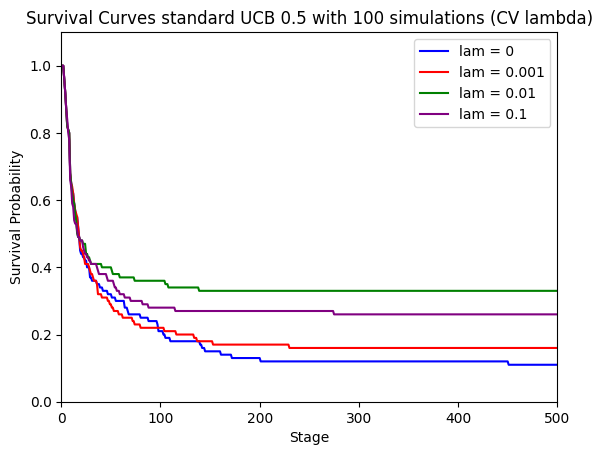

In [268]:
survivallam0 = np.zeros(nplays+1)
survivallam1 = np.zeros(nplays+1)
survivallam10 = np.zeros(nplays+1)
survivallam100 = np.zeros(nplays+1)
survivalPerotto = np.zeros(nplays+1)
survivalPerotto1 = np.zeros(nplays+1)
survivalPerotto10 = np.zeros(nplays+1)

for i in range(nplays+1):
    survivallam0[i] = sum(timeruinlam0 >= i+1)/len(timeruinlam0)
    survivallam1[i] = sum(timeruinlam1 >= i+1)/len(timeruinlam1)
    survivallam10[i] = sum(timeruinlam10 >= i+1)/len(timeruinlam10)
    survivallam100[i] = sum(timeruinlam100 >= i+1)/len(timeruinlam100)
    survivalPerotto[i] = sum(timeruinPerotto >= i+1)/len(timeruinPerotto)
    survivalPerotto1[i] = sum(timeruinPerotto1 >= i+1)/len(timeruinPerotto1)
    survivalPerotto10[i] = sum(timeruinPerotto10 >= i+1)/len(timeruinPerotto10)
print(range(1, nplays + 1))
# Create the plot
plt.plot(range(1, nplays + 2), survivallam0, color='blue', linestyle='-', label='lam = 0')
plt.plot(range(1, nplays + 2), survivallam1, color='red', linestyle='-', label=f'lam = {lam1}')
plt.plot(range(1, nplays + 2), survivallam10, color='green', linestyle='-', label=f'lam = {lam2}')
plt.plot(range(1, nplays + 2), survivallam100, color='purple', linestyle='-', label=f'lam = {lam3}')

# plt.plot(range(1, nplays + 2), survivalPerotto, color='orange', linestyle='--', label=f'Perotto')
# plt.plot(range(1, nplays + 2), survivalPerotto1, color='red', linestyle='--', label=f'Perotto lam = {lam1}')
# plt.plot(range(1, nplays + 2), survivalPerotto10, color='purple', linestyle='--', label=f'Perotto lam = {lam3}')

# Add titles and labels
plt.xlabel('Stage')
plt.ylabel('Survival Probability')
plt.title(f'Survival Curves standard UCB {aa} with {trials} simulations (CV lambda)')
plt.ylim(0, 1.1)
plt.xlim(0, 500)
# Add the legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

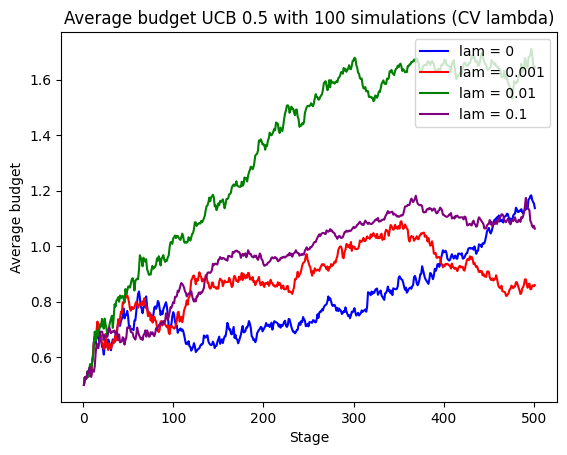

In [270]:
# Create the plot
plt.plot(range(1, nplays + 2), np.mean(budgetlam0, axis = 0), color='blue', linestyle='-', label='lam = 0')
plt.plot(range(1, nplays + 2), np.mean(budgetlam1, axis = 0), color='red', linestyle='-', label=f'lam = {lam1}')
plt.plot(range(1, nplays + 2), np.mean(budgetlam10, axis = 0), color='green', linestyle='-', label=f'lam = {lam2}')
plt.plot(range(1, nplays + 2), np.mean(budgetlam100, axis = 0), color='purple', linestyle='-', label=f'lam = {lam3}')
# plt.plot(range(1, nplays + 2), np.mean(budgetPerotto, axis = 0), color='orange', linestyle='--', label='Perotto')
# plt.plot(range(1, nplays + 2), np.mean(budgetPerotto1, axis = 0), color='red', linestyle='--', label=f'Perotto lam = {lam1}')
# plt.plot(range(1, nplays + 2), np.mean(budgetPerotto10, axis = 0), color='purple', linestyle='--', label=f'Perotto lam = {lam3}')

# Add titles and labels
plt.xlabel('Stage')
plt.ylabel('Average budget')
plt.title(f'Average budget UCB {aa} with {trials} simulations (CV lambda)')

# Add the legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

## Stylizing

In [98]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])
